In [6]:
import numpy as np
import pandas as pd
import math

import itertools

import os
import sys
sys.path.insert(0, "../")

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from plotWafer import plotWafer
from train import emd

import os

import tensorflow as tf
from tensorflow import keras

import tensorflow
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, BatchNormalization, Activation, Average, Conv2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.regularizers import l1_l2

print(tf.version.VERSION)

arrange443 = np.array([0,16, 32,
                       1,17, 33,
                       2,18, 34,
                       3,19, 35,
                       4,20, 36,
                       5,21, 37,
                       6,22, 38,
                       7,23, 39,
                       8,24, 40,
                       9,25, 41,
                       10,26, 42,
                       11,27, 43,
                       12,28, 44,
                       13,29, 45,
                       14,30, 46,
                       15,31, 47])
print(1)

2.4.1
1


In [7]:
current_directory=os.getcwd()
data_directory=os.path.join(current_directory,r'data/ttbar_v11_eolNoise_Layer9_5Links.csv')
f_raw = (data_directory)

calQ     = np.genfromtxt(f_raw, delimiter=',',usecols=[*range(0, 48)],skip_header=2000,max_rows=300)
sumQ     = calQ.sum(axis=1)
calQ     = calQ[sumQ>0]
sumQ     = sumQ[sumQ>0]
occ = (np.count_nonzero(calQ>1,axis=1))

# reshape into 443 and normalize (as is usually done for autoencoder)
calQ_443 = (calQ/np.expand_dims(sumQ,-1))[:,arrange443].reshape(-1,4,4,3)

# split train and validation so there is no overlap in samples whatsoever
train_indices = range(0, int(0.6*len(calQ)))
val_indices = range(int(0.6*len(calQ)), len(calQ))

idx1_train = np.array([i for i,j in itertools.product(train_indices,train_indices)])
idx2_train = np.array([j for i,j in itertools.product(train_indices,train_indices)])

use443 = True
if use443: 
    X = calQ_443
else:
    X = calQ
X1_train = X[idx1_train]
X2_train = X[idx2_train]
y_train = np.array([emd(calQ[i],calQ[j]) for i, j in zip(idx1_train, idx2_train)])

idx1_val = np.array([i for i,j in itertools.product(val_indices,val_indices)])
idx2_val = np.array([j for i,j in itertools.product(val_indices,val_indices)])

X1_val = X[idx1_val]
X2_val = X[idx2_val]
y_val = np.array([emd(calQ[i],calQ[j]) for i, j in zip(idx1_val, idx2_val)])

print(X1_train.shape)
print(X2_train.shape)
print(y_train.shape)

print(X1_val.shape)
print(X2_val.shape)
print(y_val.shape)

(25600, 4, 4, 3)
(25600, 4, 4, 3)
(25600,)
(11664, 4, 4, 3)
(11664, 4, 4, 3)
(11664,)


In [8]:
#Load Models
model_directory=os.path.join(current_directory,r'Best/1.h5')
print(model_directory)

input1 = Input(shape=(4, 4, 3,), name='input_1')
input2 = Input(shape=(4, 4, 3,), name='input_2')
x = Concatenate(name='concat')([input1, input2])

output = Dense(1, name='output')(x)

model = load_model(model_directory)
model.summary()


# make a model that enforces the symmetry of the EMD function by averging the outputs for swapped inputs

output = Average(name='average')([model((input1, input2)), model((input2, input1))])
sym_model = Model(inputs=[input1, input2], outputs=output, name='sym_model')
sym_model.summary()

/home/jovyan/Best/8.h5
Model: "sym_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4, 4, 3)]    0                                            
__________________________________________________________________________________________________
base_model (Functional)         (None, 1)            1776385     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 in

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!mkdir -p load-models
callbacks = [ModelCheckpoint('load-models/testemd_model_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
             ModelCheckpoint('load-models/testemd_model_last.h5', monitor='val_loss', verbose=1, save_last_only=True),
            ]
    
sym_model.compile(optimizer='adam', loss='msle', metrics=['mse', 'mae', 'mape', 'msle'])
history = sym_model.fit((X1_train, X2_train), y_train, 
                    validation_data=((X1_val, X2_val), y_val),
                    epochs=1, verbose=1, batch_size=32, callbacks=callbacks)

800/800 [==============================] - 14s 15ms/step - loss: 0.0083 - mse: 0.2460 - mae: 0.3842 - mape: 845263.1073 - msle: 0.0059 - val_loss: 0.0095 - val_mse: 0.2319 - val_mae: 0.3681 - val_mape: 1647378.2500 - val_msle: 0.0069

Epoch 00001: val_loss improved from inf to 0.00946, saving model to load-models/testemd_model_best.h5

Epoch 00001: saving model to load-models/testemd_model_last.h5


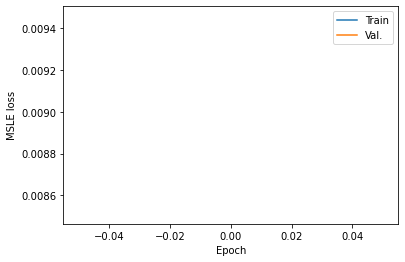

In [11]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val.')
plt.xlabel('Epoch')
plt.ylabel('MSLE loss')
plt.legend()

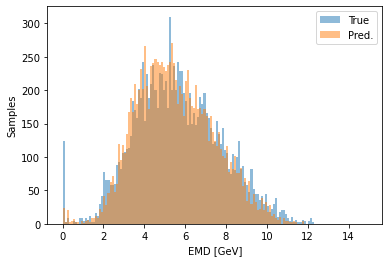

In [12]:
y_val_preds = sym_model.predict((X1_val, X2_val))
plt.figure()
plt.hist(y_val, alpha=0.5, bins=np.arange(0, 15, 0.1), label='True')
plt.hist(y_val_preds, alpha=0.5, bins=np.arange(0, 15, 0.1), label='Pred.')
plt.xlabel('EMD [GeV]')
plt.ylabel('Samples')
plt.legend()
plt.show()

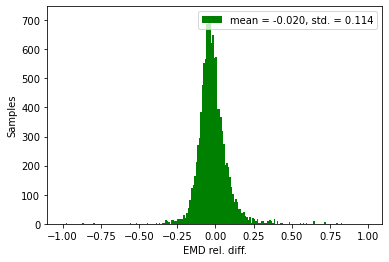

In [13]:
rel_diff = (y_val_preds[y_val>0].flatten()-y_val[y_val>0].flatten())/y_val[y_val>0].flatten()
plt.figure()
plt.hist(rel_diff, bins=np.arange(-1, 1, 0.01), color='green', label = 'mean = {:.3f}, std. = {:.3f}'.format(np.mean(rel_diff), np.std(rel_diff)))
plt.xlabel('EMD rel. diff.')
plt.ylabel('Samples')
plt.legend()
plt.show()

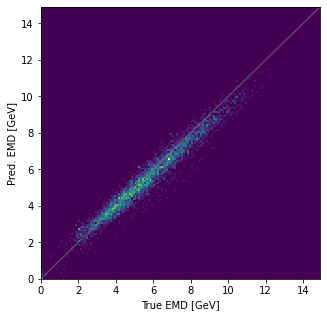

In [14]:
fig, ax = plt.subplots(figsize =(5, 5)) 
x_bins = np.arange(0, 15, 0.1)
y_bins = np.arange(0, 15, 0.1)
plt.hist2d(y_val.flatten(), y_val_preds.flatten(), bins=[x_bins,y_bins])
plt.plot([0, 15], [0, 15], color='gray', alpha=0.5)
ax.set_xlabel('True EMD [GeV]')
ax.set_ylabel('Pred. EMD [GeV]')
plt.show()